# Práctica 3: Trabajo Final

Docente: Gustavo Landfried
Inferencia Bayesiana Causal 1
1er cuatrimestre 2025
UNSAM

Alumno: Tomás Pablo Korenblit
*Estimación de desempeño de tests diagnósticos conociendo el estado de las muestras pero con datos falsificados o cargados con error.*

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch
import seaborn as sns

np.random.seed(16)

In [2]:
def draw_causal_graph(edge_list, graph_direction="TB", node_props=None, edge_props=None, figsize=(10, 8)):
    """Visualización del grafo causal usando networkx"""
    G = nx.DiGraph()
    G.add_edges_from(edge_list)

    if graph_direction in {"LR", "TB", "BT", "RL"}:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args=f'-Grankdir={graph_direction}')
    else:
        pos = nx.spring_layout(G, k=3, iterations=50)

    plt.figure(figsize=figsize)
    default_node_color = 'lightblue'
    default_node_size = 2000

    for node in G.nodes():
        color = node_props.get(node, {}).get('color', default_node_color) if node_props else default_node_color
        size = node_props.get(node, {}).get('size', default_node_size) if node_props else default_node_size
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_size=size, alpha=0.8)

    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowsize=20, arrowstyle='->', width=2, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    if edge_props:
        edge_labels = {edge: props['label'] for edge, props in edge_props.items() if 'label' in props}
        if edge_labels:
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

    plt.title("Modelo Causal - Tests Diagnósticos con Error de Operador", fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    return G, pos

In [3]:
# Carga y transformación de datos
df = pd.read_csv("positivos_por_tests.csv")
print("Datos originales:")
print(df.head())
print(f"\nDimensiones: {df.shape}")

Datos originales:
  Laboratorio  muestra  20par-DTU1  20par-DTU2  20par-DTU6  50par-DTU1  \
0          AS        3   66.666667       100.0       100.0       100.0   
1          VH        3  100.000000       100.0       100.0       100.0   
2          CB        3  100.000000       100.0       100.0       100.0   
3          SC        3  100.000000       100.0       100.0       100.0   
4        SU-1        3   33.333333       100.0       100.0       100.0   

   50par-DTU2  50par-DTU6  
0         100       100.0  
1         100       100.0  
2         100       100.0  
3         100       100.0  
4         100       100.0  

Dimensiones: (14, 8)


In [4]:
# Transformación a formato largo
df_long = pd.melt(df, id_vars=['Laboratorio', 'muestra'], var_name='Test_Concentracion', value_name='Porcentaje_Positivo')
df_long[['Concentracion', 'Test']] = df_long['Test_Concentracion'].str.split('-', expand=True)
df_long['Test'] = df_long['Test'].str.replace('DTU', 'DTU_')
df_long['Concentracion_num'] = df_long['Concentracion'].str.extract('(\d+)').astype(int)
df_long['Proporcion_Positiva'] = df_long['Porcentaje_Positivo'] / 100
df_long['n_muestras'] = 3
df_long['n_positivos'] = np.round(df_long['Proporcion_Positiva'] * df_long['n_muestras']).astype(int)

print("\nDatos transformados:")
print(df_long.head(10))


Datos transformados:
  Laboratorio  muestra Test_Concentracion  Porcentaje_Positivo Concentracion  \
0          AS        3         20par-DTU1            66.666667         20par   
1          VH        3         20par-DTU1           100.000000         20par   
2          CB        3         20par-DTU1           100.000000         20par   
3          SC        3         20par-DTU1           100.000000         20par   
4        SU-1        3         20par-DTU1            33.333333         20par   
5        SU-2        3         20par-DTU1           100.000000         20par   
6        TA-1        3         20par-DTU1            66.666667         20par   
7        TA-2        3         20par-DTU1            66.666667         20par   
8        YA-1        3         20par-DTU1            33.333333         20par   
9        YA-2        3         20par-DTU1           100.000000         20par   

    Test  Concentracion_num  Proporcion_Positiva  n_muestras  n_positivos  
0  DTU_1             

### 3.1 Problema de investigación

El objetivo es desarrollar un modelo causal que incorpore la posibilidad de error en los operadores, demostrando diferencias significativas en el desempeño de los tres tests cuando la concentración del parásito es baja.

### 3.2 Modelo Causal

Variables del modelo:
- **C**: Concentración del parásito (20 o 50 par.Eq/ml)
- **T**: Tipo de test (DTU1, DTU2, DTU6)
- **PPA**: Positive Predictive Ability del test (latente)
- **q**: Probabilidad de error del operador (latente)
- **r**: Factor de reducción de sensibilidad cuando hay error (latente)
- **Y**: Resultado observado (porcentaje de positivos)
- **V**: Estado verdadero = 1 (todas las muestras son positivas por diseño)

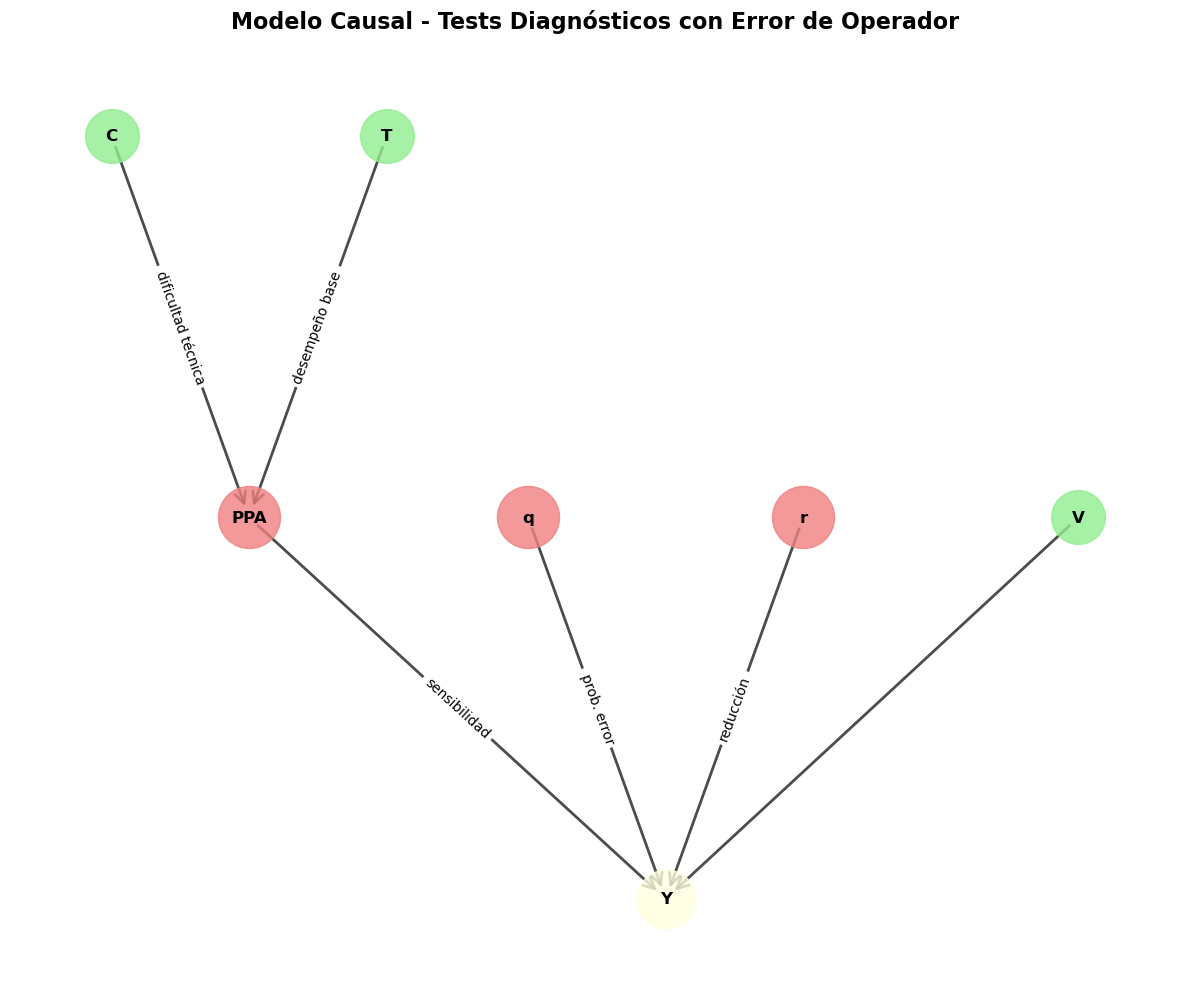

In [5]:
# Grafo causal
edge_list = [
    ("C", "PPA"),
    ("T", "PPA"),
    ("q", "Y"),
    ("r", "Y"),
    ("PPA", "Y"),
    ("V", "Y")
]

node_props = {
    "V": {"color": "lightgreen", "size": 1500},
    "C": {"color": "lightgreen", "size": 1500},
    "T": {"color": "lightgreen", "size": 1500},
    "PPA": {"color": "lightcoral", "size": 2000},
    "q": {"color": "lightcoral", "size": 2000},
    "r": {"color": "lightcoral", "size": 2000},
    "Y": {"color": "lightyellow", "size": 1800}
}

edge_props = {
    ("C", "PPA"): {"label": "dificultad técnica"},
    ("T", "PPA"): {"label": "desempeño base"},
    ("q", "Y"): {"label": "prob. error"},
    ("r", "Y"): {"label": "reducción"},
    ("PPA", "Y"): {"label": "sensibilidad"}
}

G, pos = draw_causal_graph(edge_list, graph_direction="TB", node_props=node_props, edge_props=edge_props, figsize=(12, 10))
plt.show()

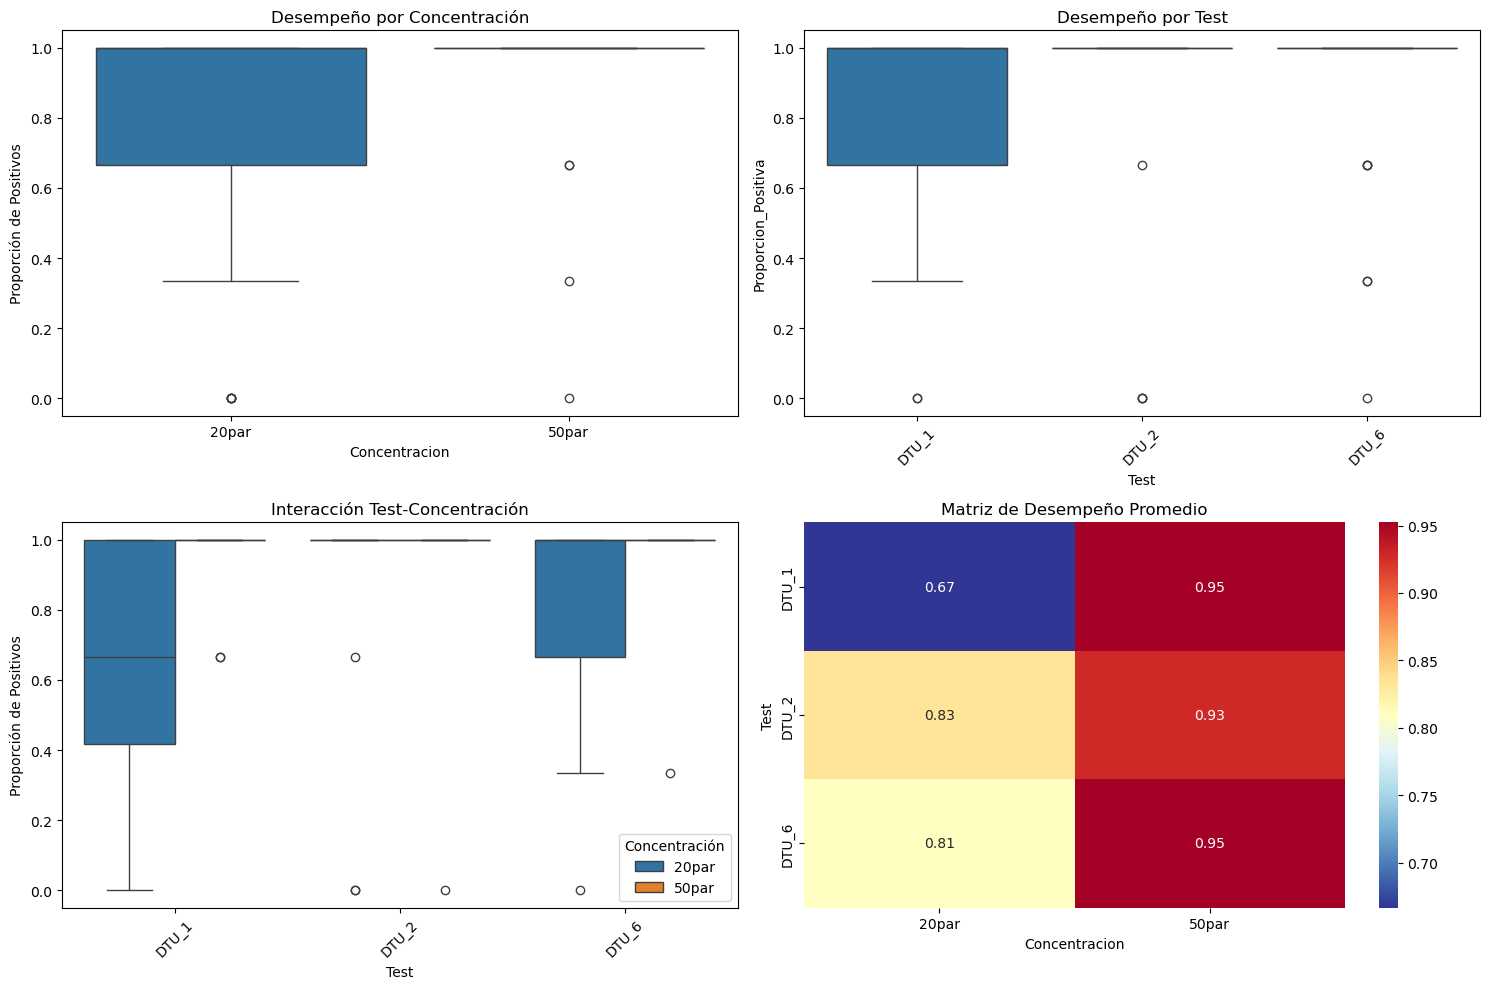

In [6]:
# Análisis exploratorio
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Desempeño por concentración
sns.boxplot(data=df_long, x='Concentracion', y='Proporcion_Positiva', ax=axes[0,0])
axes[0,0].set_title('Desempeño por Concentración')
axes[0,0].set_ylabel('Proporción de Positivos')

# Desempeño por test
sns.boxplot(data=df_long, x='Test', y='Proporcion_Positiva', ax=axes[0,1])
axes[0,1].set_title('Desempeño por Test')
axes[0,1].tick_params(axis='x', rotation=45)

# Interacción concentración-test
sns.boxplot(data=df_long, x='Test', y='Proporcion_Positiva', hue='Concentracion', ax=axes[1,0])
axes[1,0].set_title('Interacción Test-Concentración')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Proporción de Positivos')
axes[1,0].legend(title='Concentración')

# Matriz de desempeño promedio
pivot_data = df_long.pivot_table(
    values='Proporcion_Positiva', 
    index='Test', 
    columns='Concentracion', 
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1,1])
axes[1,1].set_title('Matriz de Desempeño Promedio')

plt.tight_layout()
plt.show()

In [7]:
# Análisis adicional de variabilidad
print("\nEstadísticas descriptivas por test y concentración:")
stats = df_long.groupby(['Test', 'Concentracion'])['Proporcion_Positiva'].agg(['mean', 'std', 'min', 'max'])
print(stats)


Estadísticas descriptivas por test y concentración:
                         mean       std       min  max
Test  Concentracion                                   
DTU_1 20par          0.666667  0.369800  0.000000  1.0
      50par          0.952381  0.121046  0.666667  1.0
DTU_2 20par          0.833333  0.363976  0.000000  1.0
      50par          0.928571  0.267261  0.000000  1.0
DTU_6 20par          0.809524  0.312538  0.000000  1.0
      50par          0.952381  0.178174  0.333333  1.0


In [8]:
# Análisis de diferencias entre tests
print("\nDiferencias promedio entre tests (por concentración):")
for conc in df_long['Concentracion'].unique():
    print(f"\nConcentración: {conc}")
    conc_data = df_long[df_long['Concentracion'] == conc]
    pivot = conc_data.pivot_table(
        values='Proporcion_Positiva',
        index='Test',
        aggfunc='mean'
    )
    print(pivot)


Diferencias promedio entre tests (por concentración):

Concentración: 20par
       Proporcion_Positiva
Test                      
DTU_1             0.666667
DTU_2             0.833333
DTU_6             0.809524

Concentración: 50par
       Proporcion_Positiva
Test                      
DTU_1             0.952381
DTU_2             0.928571
DTU_6             0.952381


### 3.3 Inferencia Bayesiana

Priors seleccionados:
- PPA: Beta(8, 2) para cada test en cada contexto
- q (probabilidad de error): Beta(2, 5)
- r (factor de reducción): Beta(3, 2)

In [9]:
# Preparación de datos para PyMC
labs = df_long['Laboratorio'].unique()
tests = df_long['Test'].unique()
concs = df_long['Concentracion_num'].unique()

lab_idx = pd.Categorical(df_long['Laboratorio'], categories=labs).codes
test_idx = pd.Categorical(df_long['Test'], categories=tests).codes
conc_idx = pd.Categorical(df_long['Concentracion_num'], categories=concs).codes

print(f"Laboratorios: {len(labs)} ({labs})")
print(f"Tests: {len(tests)} ({tests})")
print(f"Concentraciones: {len(concs)} ({concs})")
print(f"Observaciones totales: {len(df_long)}")

Laboratorios: 14 (['AS' 'VH' 'CB' 'SC' 'SU-1' 'SU-2' 'TA-1' 'TA-2' 'YA-1' 'YA-2' 'SE-1'
 'SE-2' 'BA' 'TG'])
Tests: 3 (['DTU_1' 'DTU_2' 'DTU_6'])
Concentraciones: 2 ([20 50])
Observaciones totales: 84


In [10]:
# Modelo Bayesiano
with pm.Model() as modelo_causal:
    # Priors para PPA de cada test en cada contexto
    # Contextos: 2-4 y 6-8 para cada test
    ppa = pm.Beta("ppa", 
                  alpha=8,  # Prior informativo para PPA
                  beta=2,
                  shape=(len(tests), 2))  # 2 contextos por test
    
    # Prior para probabilidad de error del operador
    q = pm.Beta("q", alpha=2, beta=5)  # Prior para probabilidad de error
    
    # Prior para factor de reducción de sensibilidad cuando hay error
    r = pm.Beta("r", alpha=3, beta=2)  # Prior para factor de reducción
    
    # Probabilidad de diagnóstico positivo
    # Si no hay error del operador: PPA
    # Si hay error del operador: PPA * r
    prob_positivo = (1 - q) * ppa[test_idx, conc_idx] + q * (ppa[test_idx, conc_idx] * r)
    
    # Likelihood
    y_obs = pm.Binomial("y_obs", 
                       n=df_long['n_muestras'].values, 
                       p=prob_positivo, 
                       observed=df_long['n_positivos'].values)

    print("Iniciando muestreo MCMC...")
    idata = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, return_inferencedata=True)

Iniciando muestreo MCMC...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ppa, q, r]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


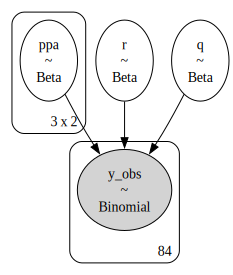

In [11]:
pm.model_to_graphviz(modelo_causal)

In [12]:
# Diagnóstico de convergencia
print("=== DIAGNÓSTICOS DE CONVERGENCIA ===")
summary = az.summary(idata)
print(summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk']])

max_rhat = summary['r_hat'].max()
print(f"\nMáximo R-hat: {max_rhat:.3f}")
if max_rhat < 1.01:
    print("✓ Convergencia exitosa (R-hat < 1.01)")
else:
    print("⚠ Posibles problemas de convergencia (R-hat >= 1.01)")

=== DIAGNÓSTICOS DE CONVERGENCIA ===
            mean     sd  hdi_3%  hdi_97%  r_hat  ess_bulk
ppa[0, 0]  0.711  0.065   0.589    0.831    1.0    7576.0
ppa[0, 1]  0.935  0.036   0.870    0.995    1.0    7594.0
ppa[1, 0]  0.846  0.053   0.746    0.941    1.0    6343.0
ppa[1, 1]  0.919  0.042   0.840    0.989    1.0    6356.0
ppa[2, 0]  0.827  0.056   0.721    0.928    1.0    7789.0
ppa[2, 1]  0.935  0.036   0.869    0.992    1.0    6883.0
q          0.154  0.114   0.004    0.363    1.0    4430.0
r          0.761  0.166   0.447    0.994    1.0    4791.0

Máximo R-hat: 1.000
✓ Convergencia exitosa (R-hat < 1.01)


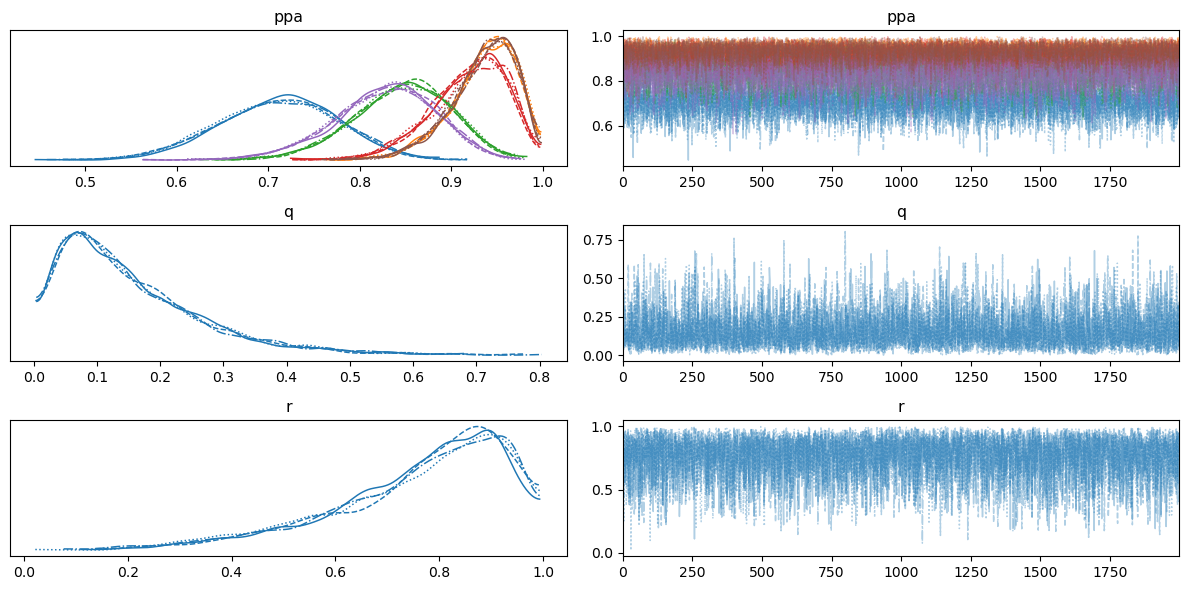

In [13]:
# Trazas de variables clave
az.plot_trace(idata, var_names=['ppa', 'q', 'r'])
plt.tight_layout()
plt.show()

### 3.4 Análisis de PPA y Error de Operador

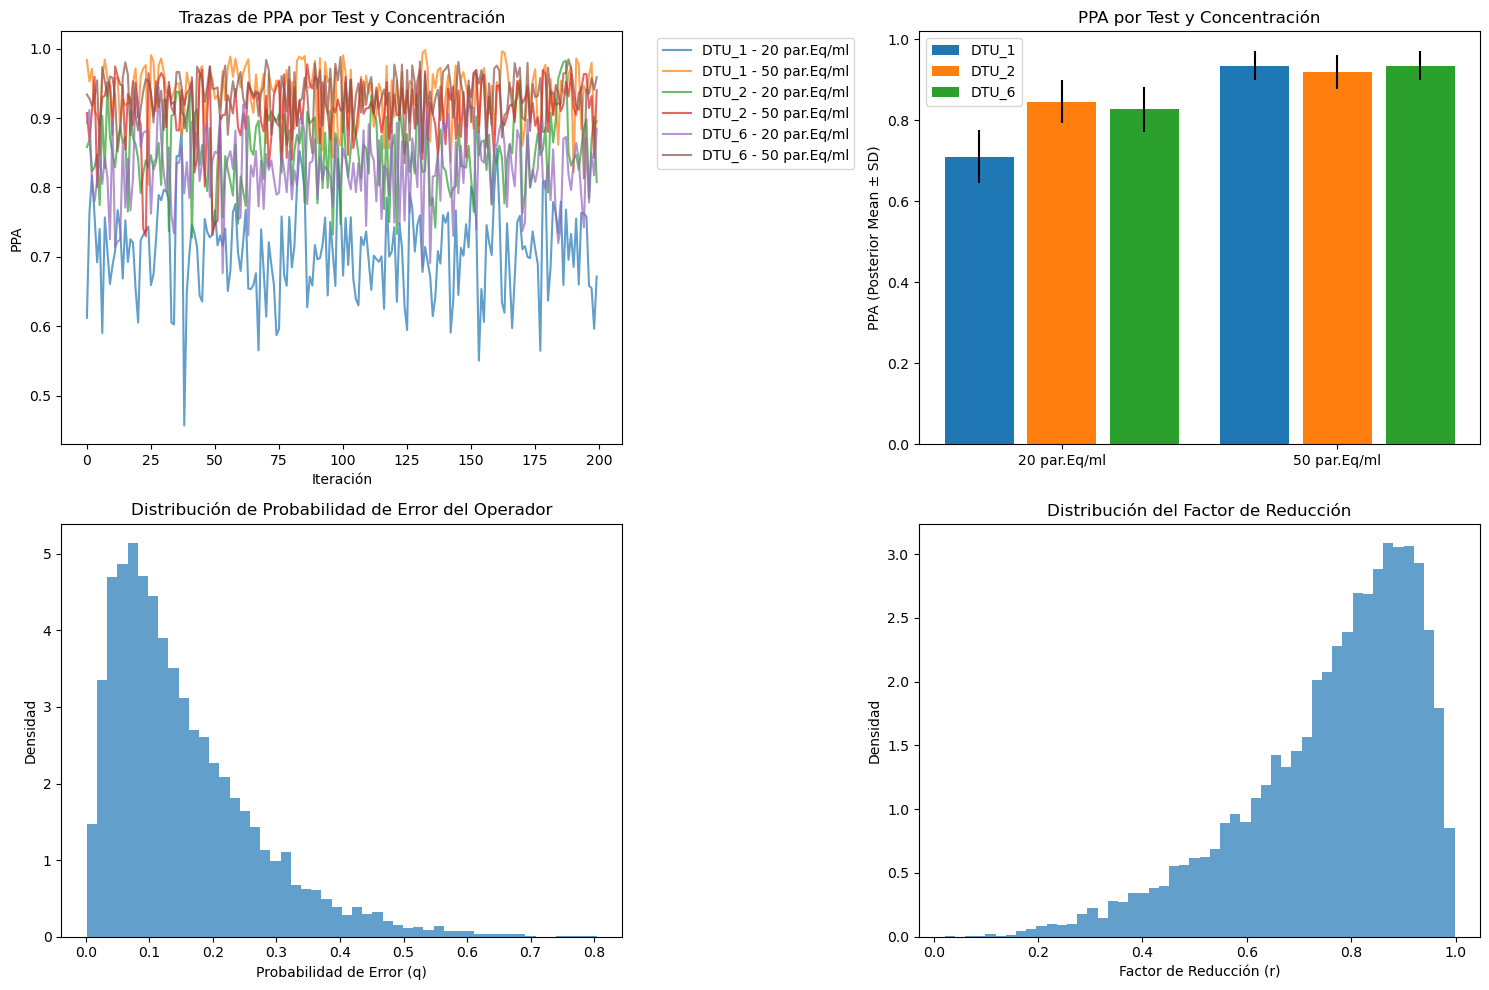

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Trazas de PPA
ppa_posterior = idata.posterior['ppa']

for i, test in enumerate(tests):
    for j, conc in enumerate(concs):
        test_samples = ppa_posterior.sel(ppa_dim_0=i, ppa_dim_1=j).values.flatten()[:200]
        axes[0,0].plot(test_samples, alpha=0.7, label=f'{test} - {conc} par.Eq/ml')
axes[0,0].set_title('Trazas de PPA por Test y Concentración')
axes[0,0].set_xlabel('Iteración')
axes[0,0].set_ylabel('PPA')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Estadísticas de PPA
ppa_mean = ppa_posterior.mean(dim=['chain', 'draw'])
ppa_std = ppa_posterior.std(dim=['chain', 'draw'])

# Gráfico de barras para PPA
for i, test in enumerate(tests):
    x = np.arange(len(concs)) + i * 0.3
    axes[0,1].bar(x, ppa_mean[i], yerr=ppa_std[i], width=0.25, label=test)
axes[0,1].set_xticks(np.arange(len(concs)) + 0.3)
axes[0,1].set_xticklabels([f'{c} par.Eq/ml' for c in concs])
axes[0,1].set_ylabel('PPA (Posterior Mean ± SD)')
axes[0,1].set_title('PPA por Test y Concentración')
axes[0,1].legend()

# Distribución de probabilidad de error
q_posterior = idata.posterior['q'].values.flatten()
axes[1,0].hist(q_posterior, bins=50, density=True, alpha=0.7)
axes[1,0].set_xlabel('Probabilidad de Error (q)')
axes[1,0].set_ylabel('Densidad')
axes[1,0].set_title('Distribución de Probabilidad de Error del Operador')

# Distribución del factor de reducción
r_posterior = idata.posterior['r'].values.flatten()
axes[1,1].hist(r_posterior, bins=50, density=True, alpha=0.7)
axes[1,1].set_xlabel('Factor de Reducción (r)')
axes[1,1].set_ylabel('Densidad')
axes[1,1].set_title('Distribución del Factor de Reducción')

plt.tight_layout()
plt.show()

### 3.5 Análisis de Desempeño de Tests

In [15]:
# Extracción de posteriores para análisis de PPA
ppa_posterior = idata.posterior['ppa']
q_posterior = idata.posterior['q'].values.flatten()
r_posterior = idata.posterior['r'].values.flatten()

# Cálculo de PPA efectiva considerando el error del operador
ppa_efectiva = {}
for test_i, test in enumerate(tests):
    ppa_efectiva[test] = {}
    for conc_i, conc in enumerate(concs):
        ppa_samples = ppa_posterior.sel(ppa_dim_0=test_i, ppa_dim_1=conc_i).values.flatten()
        # PPA efectiva = (1-q)*PPA + q*(PPA*r)
        ppa_efectiva[test][conc] = (1 - q_posterior) * ppa_samples + q_posterior * (ppa_samples * r_posterior)

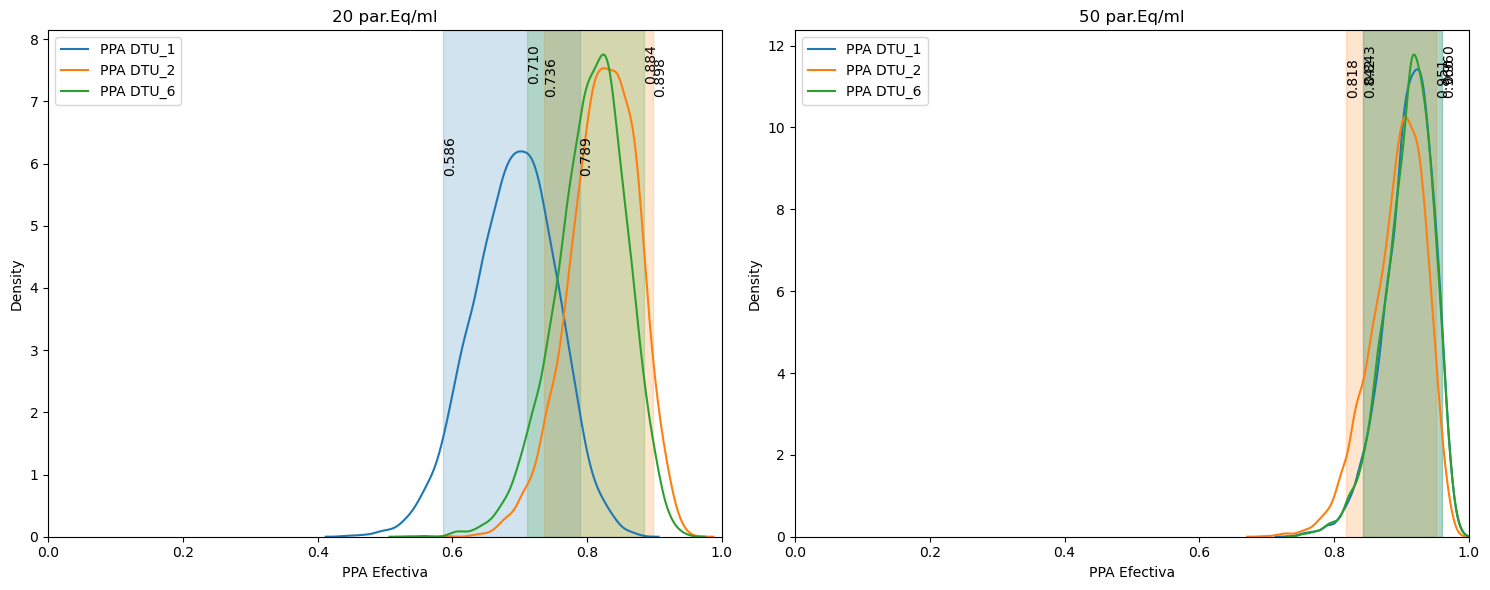

In [16]:
# Visualización de PPA efectiva por concentración
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Baja concentración (20 par.Eq/ml)
for test_i, test in enumerate(tests):
    ppa_samples = ppa_efectiva[test][20]
    sns.kdeplot(ppa_samples, ax=ax1, label=f'PPA {test}')
    
    hdi_low, hdi_high = np.percentile(ppa_samples, [5, 95])
    ax1.axvspan(hdi_low, hdi_high, alpha=0.2, color=f'C{test_i}')
    ax1.text(hdi_low, ax1.get_ylim()[1]*0.9, f'{hdi_low:.3f}', rotation=90)
    ax1.text(hdi_high, ax1.get_ylim()[1]*0.9, f'{hdi_high:.3f}', rotation=90)

ax1.set_title('20 par.Eq/ml')
ax1.set_xlabel('PPA Efectiva')
ax1.set_ylabel('Density')
ax1.set_xlim(0, 1)
ax1.legend()

# Alta concentración (50 par.Eq/ml)
for test_i, test in enumerate(tests):
    ppa_samples = ppa_efectiva[test][50]
    sns.kdeplot(ppa_samples, ax=ax2, label=f'PPA {test}')
    
    hdi_low, hdi_high = np.percentile(ppa_samples, [5, 95])
    ax2.axvspan(hdi_low, hdi_high, alpha=0.2, color=f'C{test_i}')
    ax2.text(hdi_low, ax2.get_ylim()[1]*0.9, f'{hdi_low:.3f}', rotation=90)
    ax2.text(hdi_high, ax2.get_ylim()[1]*0.9, f'{hdi_high:.3f}', rotation=90)

ax2.set_title('50 par.Eq/ml')
ax2.set_xlabel('PPA Efectiva')
ax2.set_ylabel('Density')
#ax2.set_xlim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
print("\n=== HDI INTERVALS (5% - 95%) ===")
print("\n20 par.Eq/ml:")
for test in tests:
    hdi_low, hdi_high = np.percentile(ppa_efectiva[test][20], [5, 95])
    print(f"PPA {test}: {hdi_low:.3f} - {hdi_high:.3f}")

print("\n50 par.Eq/ml:")
for test in tests:
    hdi_low, hdi_high = np.percentile(ppa_efectiva[test][50], [5, 95])
    print(f"PPA {test}: {hdi_low:.3f} - {hdi_high:.3f}")


=== HDI INTERVALS (5% - 95%) ===

20 par.Eq/ml:
PPA DTU_1: 0.586 - 0.789
PPA DTU_2: 0.736 - 0.898
PPA DTU_6: 0.710 - 0.884

50 par.Eq/ml:
PPA DTU_1: 0.842 - 0.960
PPA DTU_2: 0.818 - 0.951
PPA DTU_6: 0.843 - 0.960


In [18]:
print("=== COMPARACIONES ENTRE TESTS (CONCENTRACIÓN BAJA: 20 par.Eq/ml) ===\n")

conc_baja_idx = 0
ppa_baja = {test: ppa_efectiva[test][concs[conc_baja_idx]] for test in tests}

comparaciones = [('DTU_1', 'DTU_2'), ('DTU_1', 'DTU_6'), ('DTU_2', 'DTU_6')]

for test1, test2 in comparaciones:
    if test1 in ppa_baja and test2 in ppa_baja:
        prob_superior = (ppa_baja[test1] > ppa_baja[test2]).mean()
        print(f"P({test1} > {test2} | Datos) = {prob_superior:.4f}")

=== COMPARACIONES ENTRE TESTS (CONCENTRACIÓN BAJA: 20 par.Eq/ml) ===

P(DTU_1 > DTU_2 | Datos) = 0.0498
P(DTU_1 > DTU_6 | Datos) = 0.0838
P(DTU_2 > DTU_6 | Datos) = 0.5982


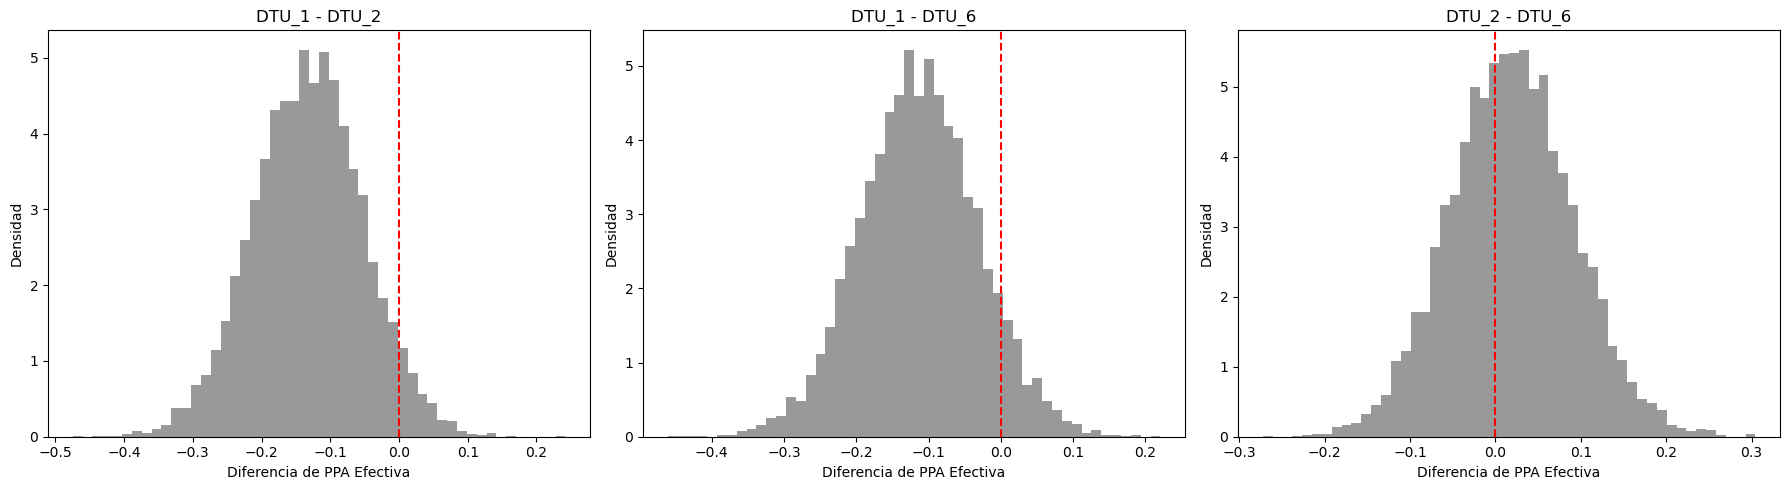

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (test1, test2) in enumerate(comparaciones):
    diff = ppa_baja[test1] - ppa_baja[test2]
    axes[i].hist(diff, bins=50, color='gray', alpha=0.8, density=True)
    axes[i].axvline(0, color='red', linestyle='--')
    axes[i].set_title(f'{test1} - {test2}')
    axes[i].set_xlabel('Diferencia de PPA Efectiva')
    axes[i].set_ylabel('Densidad')

plt.tight_layout()
plt.show()